# Fetch weather data script

Author: Chris Bahlo

The goal of this notebook is to attach weather data statistics from the SILO API to a dataset containing latitude, longitude and date columns. It was originally written to add weather data to a livestock worm resistance results dataset, but it has also been used (with modification to the date range calculations) in another research project. 

Two examples of mapping the dataset are also included.


In [46]:
import os
import io
import pandas as pd
import numpy as np
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
#from csv import DictReader
import datetime
import urllib
import json
import math

# for mapping stuff at end (not currently used)
from shapely.geometry import Point, Polygon
import folium
from folium import plugins
from pyproj import CRS
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es



## Specify settings

In [79]:
# specify the number of days to fetch 
# note: this is currently calculated BEFORE the trialDate (see below)
daysToFetch = 30

# specify date formats (dateFormatInput may need to be updated depending on input file)
dateFormatSilo = "%Y%m%d"
dateFormatInput = '%d/%m/%Y'

# specify config file name
configFile = "config.json"

# Define data sources and output files

# specify input file and named sheet
# excelInputFile = "sample.xlsx"
# excelSheet = "Sheet1"

# alternatively, specify csv input file
csvInputFile = "sample.csv"

# specify output file
excelOutputFile = "./outputs/test_results.xlsx"
csvOutputFile = "./outputs/test_results.csv"

# specify output column names
trialDate = "test_date"
colLatitude = "lat"
colLongitude = "long"

In [80]:
# fetch contents of excel file with sheep drench data into the dataframe to work with
#drenchData = pd.read_excel(excelInputFile, sheet_name=excelSheet, header=0)

# alternatively, read from a csv file:
drenchData = pd.read_csv(csvInputFile, encoding='utf-8')

# show content of first few rows to see the columnn names of lon/late and date fields
drenchData.head(10)

,test_date,property,lat,long,year,drench,efficacy
0,26/11/2023,Happy Valley Farm,-37.283,141.809,2023,ABC,0.8
1,25/10/2023,Billy Joe's Farm,-37.584,141.091,2023,DEF,0.7


In [81]:
# fetch SILO and DB credentials from config.json

try:
    with open(configFile, 'r') as f:
        credentials = json.load(f)
        print("SILO credentials loaded")

except IOError:
    print('Could not open config file, exiting.')
    exit()

silo_user = credentials["silo_user"]
silo_pw = credentials["silo_pw"]



SILO credentials loaded


In [82]:
# The dataset may have missing values in some lat, long and date fields

# identify rows with missing data anywhere

# missingData = drenchData.loc[drenchData.isna().any(axis=1)]

# print(f"Total number of missing values in dataframe: {drenchData.isna().sum().sum()}\n")
# print(missingData)

In [83]:
# identify rows with missing lat values and clean these rows out. 
# if all rows contain a lat field, the drenchData dataframe is left unchanged
                     
print(f"Total number of missing values latitude values: {drenchData[colLatitude].isna().sum().sum()}\n")
print(f"Total number of missing date values: {drenchData[trialDate].isna().sum().sum()}\n")

# drop rows with missing locations and dates from dataframe
# drenchData = drenchData.dropna(subset=[latitude])
# drenchData = drenchData.dropna(subset=[longitude])
# drenchData = drenchData.dropna(subset=[trialDate])


Total number of missing values latitude values: 0

Total number of missing date values: 0



## Function Declarations

In [84]:
# declare functions for stats calcs where no inbuilt fn is available:
def range(series):
    return series.max() - series.min()

# calculate interquartile range
def get_iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    return q75 - q25

In [85]:
# this function returns an array with end date and start date string formatted for the SILO API,using the specified number of days

def getDateRange(currentTrialDate):
    

    # convert date string into date object (if needed) and set element 0 of dateRange array to be the finish date
    if isinstance(currentTrialDate, datetime.datetime):
        endDate = currentTrialDate
    else:
        endDate = datetime.datetime.strptime(currentTrialDate, dateFormatInput)

    # calculate the start date as: no of previous days to fetch before end date and set as dateRange array element 1
    #dateRange.append(dateRange[0] - datetime.timedelta(days=daysToFetch))
    startDate = endDate - datetime.timedelta(days=daysToFetch-1)

    # convert dates to date format that SILO understands
    startDate = startDate.strftime(dateFormatSilo)
    endDate = endDate.strftime(dateFormatSilo)
    
    return startDate, endDate
    

In [86]:
# query the SILO point API  with the given dates and coords
# return a dataframe with that part of the api response which contains the required weather data

def getSILOData(startDate, endDate, lat, lon):
    
    # Query SILO API for the date range and lat/lon from the source spreadsheet
    silo_params = {
          'username': silo_user,
          'password': silo_pw,
          'start': startDate,
          'finish': endDate,
          'lat': lat,
          'lon': lon,
          'format': 'alldata'  
          }

    query = urllib.parse.urlencode(silo_params)

    silo_uri = 'https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?{}'.format(query)

    # testing
    # print(silo_uri)

    try:
        response = urllib.request.urlopen(silo_uri)
        data = response.read()
    except urllib.error.URLError as e:
        print(e.reason)
    
    # the first 45 rows contain metadata, use below two lines to output complete record if required
    # siloCompleteRecord = pd.read_csv(io.BytesIO(data), delim_whitespace=True)
    # siloCompleteRecord.to_csv(f"./test_outputs/complete_SILO_data_{startDate}-{endDate}_{lat}-{lon}.csv")
    
    # read weather info from returned data string, starting at row 46
    siloData = pd.read_csv(io.BytesIO(data), delim_whitespace=True, header=46)

    # first row contains units of measurement, save in a separate df (in case we need it) and then drop that row
    measurementUnits = siloData.head(1)
    siloData = siloData.tail(-1)

 
    # relevant source columns: Max temp, Min temp, Rainfall, Evaporation, Radiation and Vapour Pressure
    columns = ["T.Max", "T.Min", "Rain", "Evap", "Radn", "VP"]
    
    # convert columns to numeric data
    siloData[columns] = siloData[columns].apply(pd.to_numeric)
    
    return siloData
    
    

In [87]:
# loop to fetch weather data for a dataframe (or subset

# set limit for testing (1 to get the first one only, -1 to get all records)
limit = -1

for index, row in drenchData.iterrows():

    if index == limit: 
        break

    # test if there is a valid date, then if there is a lat/long
   
    if pd.isna(row[trialDate]) :
        
        print(f"not processed: {index}")

        continue
    #else:
        # should check here if valid date!
        
        if math.isnan(row[colLatitude]):
            continue
        
    
    # get date range and lat/long info for Silo request
    startDate, endDate = getDateRange(row[trialDate])    

    lat = row[colLatitude]
    long = row[colLongitude]
    print(f"Row {index}: getting data from {startDate} to {endDate} for latitude, longitude: {lat},{long}")
    
    # call function that queries the api
    siloData = getSILOData(startDate, endDate, lat, long)
    
    # output SILO data to csv file if required
    #siloData.to_csv(f"./test_outputs/SILO_data_{startDate}-{endDate}_{latitude}-{longitude}.csv", sep=',', encoding='utf-8')  
    
    
    # From here down, calculate stats for the silo data:
    
    # specify new array for 6 columns to obtain stats for
    stats = [{"name": "T.Max"}, {"name": "T.Min"}, {"name": "Rain"}, {"name": "Evap"}, {"name": "Radn"}, {"name": "VP"}]
    
    for stat in stats:
    
        name = stat["name"]

        # use aggregate functions to determine some values (min, max not used)
        stat.update(siloData[name].agg(["min", "max", range, "mean", "median", "std"]))

        stat["var"] = siloData[name].var()
        stat["irq"] = get_iqr(siloData[name])

        # mode can have more than one value, so this returns an array
        mode = siloData[name].mode()
        #stat["mode"] = mode

        # store mode values as comma delimted string
        stat["mode"] = ','.join([str(m) for m in mode])


    # assign the list of values to a dataframe for further handling/viewing
    df_stats = pd.DataFrame(stats)
    
    # testing
    # print(df_stats)

    # testing: save test outputs as csv
    # df_stats.to_csv("./test_outputs/test-stats.csv", sep=',', encoding='utf-8')  
    
    # testing
    # print(f"index = {index}")
    
    # update drench Data df with stats
    drenchData.loc[index,"mean T.Max"] = df_stats.iloc[0]["mean"]
    drenchData.loc[index,"mean T.Mim"] = df_stats.iloc[1]["mean"]
    drenchData.loc[index,"mean Rain"] = df_stats.iloc[2]["mean"]
    drenchData.loc[index,"mean Evap"] = df_stats.iloc[3]["mean"]
    drenchData.loc[index,"mean Radn"] = df_stats.iloc[4]["mean"]
    drenchData.loc[index,"mean VP"] = df_stats.iloc[5]["mean"]
    
    drenchData.loc[index,"median T.Max"] = df_stats.iloc[0]["median"]
    drenchData.loc[index,"median T.Mim"] = df_stats.iloc[1]["median"]
    drenchData.loc[index,"median Rain"] = df_stats.iloc[2]["median"]
    drenchData.loc[index,"median Evap"] = df_stats.iloc[3]["median"]
    drenchData.loc[index,"median Radn"] = df_stats.iloc[4]["median"]
    drenchData.loc[index,"median VP"] = df_stats.iloc[5]["median"]
    
    drenchData.loc[index,"std T.Max"] = df_stats.iloc[0]["std"]
    drenchData.loc[index,"std T.Mim"] = df_stats.iloc[1]["std"]
    drenchData.loc[index,"std Rain"] = df_stats.iloc[2]["std"]
    drenchData.loc[index,"std Evap"] = df_stats.iloc[3]["std"]
    drenchData.loc[index,"std Radn"] = df_stats.iloc[4]["std"]
    drenchData.loc[index,"std VP"] = df_stats.iloc[5]["std"]
    
    drenchData.loc[index,"range T.Max"] = df_stats.iloc[0]["range"]
    drenchData.loc[index,"range T.Mim"] = df_stats.iloc[1]["range"]
    drenchData.loc[index,"range Rain"] = df_stats.iloc[2]["range"]
    drenchData.loc[index,"range Evap"] = df_stats.iloc[3]["range"]
    drenchData.loc[index,"range Radn"] = df_stats.iloc[4]["range"]
    drenchData.loc[index,"range VP"] = df_stats.iloc[5]["range"]
    
    drenchData.loc[index,"var T.Max"] = df_stats.iloc[0]["var"]
    drenchData.loc[index,"var T.Mim"] = df_stats.iloc[1]["var"]
    drenchData.loc[index,"var Rain"] = df_stats.iloc[2]["var"]
    drenchData.loc[index,"var Evap"] = df_stats.iloc[3]["var"]
    drenchData.loc[index,"var Radn"] = df_stats.iloc[4]["var"]
    drenchData.loc[index,"var VP"] = df_stats.iloc[5]["var"]
    
    drenchData.loc[index,"irq T.Max"] = df_stats.iloc[0]["irq"]
    drenchData.loc[index,"irq T.Mim"] = df_stats.iloc[1]["irq"]
    drenchData.loc[index,"irq Rain"] = df_stats.iloc[2]["irq"]
    drenchData.loc[index,"irq Evap"] = df_stats.iloc[3]["irq"]
    drenchData.loc[index,"irq Radn"] = df_stats.iloc[4]["irq"]
    drenchData.loc[index,"irq VP"] = df_stats.iloc[5]["irq"]
    
    drenchData.loc[index,"mode T.Max"] = df_stats.iloc[0]["mode"]
    drenchData.loc[index,"mode T.Mim"] = df_stats.iloc[1]["mode"]
    drenchData.loc[index,"mode Rain"] = df_stats.iloc[2]["mode"]
    drenchData.loc[index,"mode Evap"] = df_stats.iloc[3]["mode"]
    drenchData.loc[index,"mode Radn"] = df_stats.iloc[4]["mode"]
    drenchData.loc[index,"mode VP"] = df_stats.iloc[5]["mode"]
  


Row 0: getting data from 20231028 to 20231126 for latitude, longitude: -37.283,141.809
Row 1: getting data from 20230926 to 20231025 for latitude, longitude: -37.584,141.091


In [88]:
# create new excel file with named sheet

with pd.ExcelWriter(excelOutputFile, engine="openpyxl") as writer:
    drenchData.to_excel(writer, sheet_name="30 day weather")
    
# alternatively, save as csv instead
drenchData.to_csv(csvOutputFile)

---
## Below here is unused code just to see how the points would look on a map

## Interactive Folium map

May showing markers with locations, colour coded for year

In [63]:
# showing sheep drench test locations using interactive folium map
# this helps check for invalid coords 

# list of possible pin colours - will be set depending on date
pinColours = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige',
 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink',
 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# create map, set center
map = folium.Map(location=[-37.6643, 141.7345])

# drop rows with missing locations and dates from dataframe
drenchDataValid = drenchData.dropna(subset=[colLatitude])
drenchData = drenchDataValid.dropna(subset=[colLongitude])
drenchData = drenchDataValid.dropna(subset=[trialDate])


# ---- can use this to get markers on the map if no animation is required -----
# put the markers on the map. Set colours and tooltips for each pin 
for index, d in drenchDataValid.iterrows():
    pinColour = pinColours[d["year"] - 2012]
    
    html = f"""
    <h2>{d['property']}</h2>
    <table>
    <tr>
    <td>Drench</td>
    <td>{d['drench']}</td>
    <tr>
    <td>Efficacy</td>
    <td>{d['efficacy']}</td>
    </tr>
    <tr>
    </table>
    """
    
    iframe = folium.IFrame(html, width=500, height=300)
    popUp = folium.Popup(iframe, max_width=2650)
    
    folium.Marker([d[colLatitude], d[colLongitude]], 
                  popup=popUp,
                  icon=folium.Icon(color=pinColour,icon="pastafarianism", prefix='fa'),
                  tooltip=html
                 ).add_to(map)



# ---- the below will show all markers at the same time. To have animation, I would need to add an array of coords and an array of times (matching number) to the features array.

# init geojson array
features = []

for index, d in drenchData.iterrows():
    
    # set some variables for for the point feature
    
    pinColour = pinColours[d["year"] - 2012]
    
    # ensure that if we get a date object from the dataframe, it's converted to string
    if isinstance(d[trialDate], datetime.datetime):
        testDate = d[trialDate].strftime(dateFormatInput)
    else:
        testDate = d[trialDate]
    
    # assemble a table of values for this popup instead - could improve on this
    toolTip = "<table><tr><td>Date</td><td>" + testDate + "</td></tr><td>Drench</td><td>" + d['drench'] + "</td></tr><td>Property</td><td>" + d['property'] + "</td></tr></table>"
    
    features.append(
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [d[colLongitude], d[colLatitude]],
        },
        "properties": {
            "popup": d['drench'],
            "tooltip": toolTip,
            "times": testDate,
            "icon": "circle",
            "iconstyle": {
                "fillColor": pinColour,
                "fillOpacity": 0.6,
                "stroke": "true",
                "radius": 13,
            },
            "style": {"weight": 0},
            "id": index,
        },
    }
    )
    
# test output: first feature
# print(features[0])        
        
map

In [61]:
# Convert lat long pairs to geometry for display in plot - note, this isn't used, was done for interest only, and there is an issue with the plot as well as the point to geom conversion

crs = CRS("EPSG:4326")

# set crs and add geometry columnn
geometry = [Point(xy) for xy in zip(drenchData['long'], drenchData['lat'])]

# create geodataframe
geoDrenchData = gpd.GeoDataFrame(drenchData,
                                 crs=crs,
                                 geometry=geometry)
geoDrenchData.head()

,test_date,property,lat,long,year,drench,efficacy,mean T.Max,mean T.Mim,mean Rain,...,irq Evap,irq Radn,irq VP,mode T.Max,mode T.Mim,mode Rain,mode Evap,mode Radn,mode VP,geometry
0,26/11/2023,Happy Valley Farm,-37.283,141.809,2023,ABC,0.8,22.563333,8.256667,2.116667,...,1.05,7.55,3.200,"18.3,19.0,19.4","5.5,7.0,8.3,10.6",0.0,5.7,"26.7,27.5","9.0,9.9,13.6",POINT (141.80900 -37.28300)
1,25/10/2023,Billy Joe's Farm,-37.584,140.091,2023,DEF,0.7,18.733333,7.920000,0.573333,...,1.85,3.15,1.875,15.6,"4.2,9.5",0.0,3.3,"18.5,20.7,20.8,21.2,21.9,24.7","10.0,10.4,11.1",POINT (140.09100 -37.58400)


In [72]:
# show basemap options
cx.providers.keys()

dict_keys(['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'Stamen', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'Gaode', 'Strava', 'OrdnanceSurvey'])

In [78]:
# tilesets from OpenStreetMap
cx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'BlackAndWhite'])

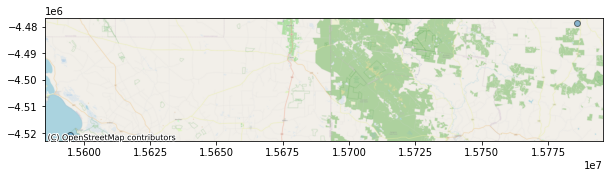

In [ ]:
# show sheep drench data as static plots using contextily
# note there is an issue with adding the base maps and it only works part time
# don't really need this for the SILO import, was for interest only

# convert crs for display with base layer
geoDrenchData = geoDrenchData.to_crs(epsg=3857)

ax = geoDrenchData.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")

cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)